In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.metrics import classification_report

In [7]:
df = pd.read_csv("D:/Sentimental data analysis/cleaned_sentiment_data.csv")

# Basic info
print(df.info())

# First few rows
print(df.head())

# Check for null values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  732 non-null    int64  
 1   Unnamed: 0    732 non-null    int64  
 2   Text          732 non-null    object 
 3   Sentiment     732 non-null    object 
 4   Timestamp     732 non-null    object 
 5   User          732 non-null    object 
 6   Platform      732 non-null    object 
 7   Hashtags      732 non-null    object 
 8   Retweets      732 non-null    float64
 9   Likes         732 non-null    float64
 10  Country       732 non-null    object 
 11  Year          732 non-null    int64  
 12  Month         732 non-null    int64  
 13  Day           732 non-null    int64  
 14  Hour          732 non-null    int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 85.9+ KB
None
   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2  

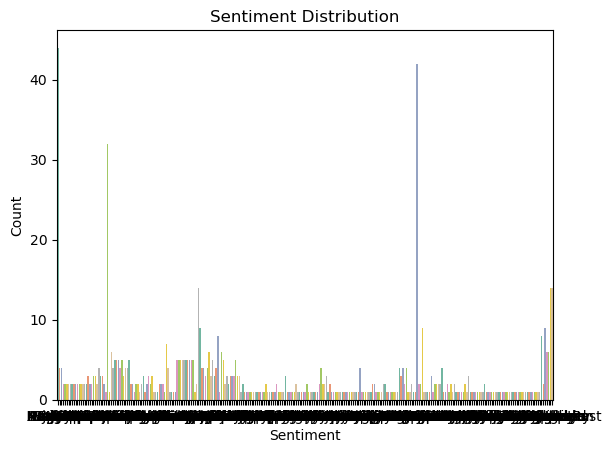

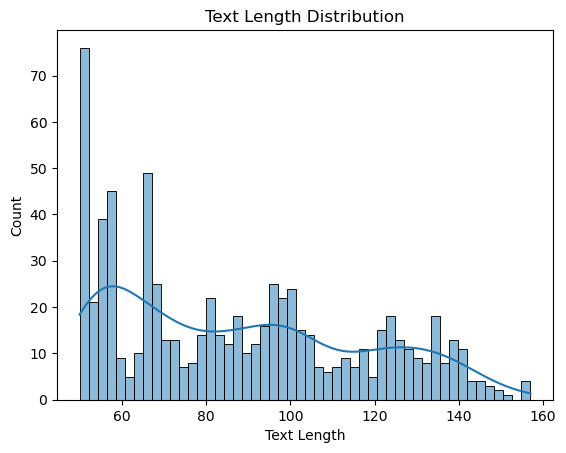

In [15]:
sns.countplot(data=df, x='Sentiment', hue='Sentiment', palette='Set2', legend=False)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Text length distribution
df['text_length'] = df['Text'].apply(len)
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.show()

In [57]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_text'] = df['Text'].astype(str).apply(clean_text)
print(df['clean_text'].head())

0           enjoy beauti day park
1            traffic terribl morn
2             finish amaz workout
3     excit upcom weekend getaway
4    tri new recip dinner tonight
Name: clean_text, dtype: object


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\V2IN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
print(df['clean_text'].head())
df['Sentiment'].unique()

0           enjoy beauti day park
1            traffic terribl morn
2             finish amaz workout
3     excit upcom weekend getaway
4    tri new recip dinner tonight
Name: clean_text, dtype: object


array([' positive  ', ' negative  ', ' neutral   ', ' anger        ',
       ' fear         ', ' sadness      ', ' disgust      ',
       ' happiness    ', ' joy          ', ' love         ',
       ' amusement    ', ' enjoyment    ', ' admiration   ',
       ' affection    ', ' awe          ', ' disappointed ',
       ' surprise     ', ' acceptance   ', ' adoration    ',
       ' anticipation ', ' bitter       ', ' calmness     ',
       ' confusion    ', ' excitement   ', ' kind         ',
       ' pride        ', ' shame        ', ' confusion ', ' excitement ',
       ' shame ', ' elation       ', ' euphoria      ', ' contentment   ',
       ' serenity      ', ' gratitude     ', ' hope          ',
       ' empowerment   ', ' compassion    ', ' tenderness    ',
       ' arousal       ', ' enthusiasm    ', ' fulfillment  ',
       ' reverence     ', ' compassion', ' fulfillment   ', ' reverence ',
       ' elation   ', ' despair         ', ' grief           ',
       ' loneliness     

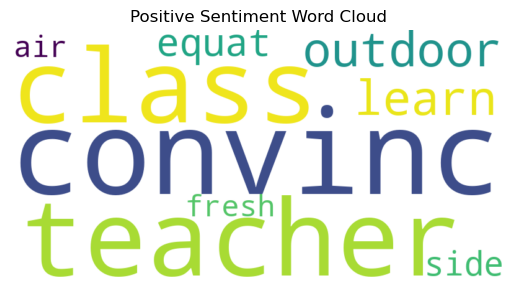

In [99]:
# Ensure Sentiment is lowercase
df['Sentiment'] = df['Sentiment'].str.lower()

# Filter and drop NaNs
positive_texts = df[df['Sentiment'] == ' positive ']['clean_text'].dropna().astype(str)
positive_texts = positive_texts[positive_texts.str.strip() != '']  # remove empty strings

# Generate word cloud
if not positive_texts.empty:
    pos_words = ' '.join(positive_texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(pos_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Positive Sentiment Word Cloud")
    plt.show()
else:
    print("No non-empty clean_text found for positive sentiment.")

In [107]:
from textblob import TextBlob

# Function to get polarity
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply to clean text
df['polarity'] = df['clean_text'].apply(get_polarity)

# Classify based on polarity
df['predicted_sentiment'] = df['polarity'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Compare predicted vs actual (if 'sentiment' column is present)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)  # Train the model
print(df[['Sentiment', 'predicted_sentiment']].head())

     Sentiment predicted_sentiment
0   positive              positive
1   negative               neutral
2   positive               neutral
3   positive               neutral
4   neutral               positive


In [129]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("cleaned_sentiment_data.csv")

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # remove mentions and hashtags
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.strip()
    return text

# Apply text cleaning
df['Clean_Text'] = df['Text'].astype(str).apply(clean_text)

# Stopword removal and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['Processed_Text'] = df['Clean_Text'].apply(preprocess)

# Features and labels
X = df['Processed_Text']
y = df['Sentiment'].str.strip()  # remove any trailing spaces

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division = 0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\V2IN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\V2IN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy: 0.19727891156462585

Classification Report:
                       precision    recall  f1-score   support

          Acceptance       1.00      1.00      1.00         2
          Admiration       0.00      0.00      0.00         2
           Affection       0.00      0.00      0.00         1
         Ambivalence       0.00      0.00      0.00         1
               Anger       0.00      0.00      0.00         1
        Anticipation       0.00      0.00      0.00         1
             Arousal       0.00      0.00      0.00         3
                 Awe       0.00      0.00      0.00         2
                 Bad       0.00      0.00      0.00         1
            Betrayal       0.00      0.00      0.00         3
              Bitter       0.00      0.00      0.00         1
          Bitterness       0.00      0.00      0.00         1
         Bittersweet       0.00      0.00      0.00         1
             Boredom       0.00      0.00      0.00         1
            Ca

In [131]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("cleaned_sentiment_data.csv")

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

# Apply cleaning
df['Clean_Text'] = df['Text'].astype(str).apply(clean_text)

# Stopword removal and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['Processed_Text'] = df['Clean_Text'].apply(preprocess)

# Features and labels
X = df['Processed_Text']
y = df['Sentiment'].str.strip()  # Ensure no trailing spaces

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# SVM model (Linear kernel)
svm_model = LinearSVC(class_weight='balanced', max_iter=10000)
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = svm_model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\V2IN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\V2IN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy: 0.42857142857142855

Classification Report:
                       precision    recall  f1-score   support

          Acceptance       0.67      1.00      0.80         2
      Accomplishment       0.00      0.00      0.00         0
          Admiration       1.00      0.50      0.67         2
           Adventure       0.00      0.00      0.00         0
           Affection       1.00      1.00      1.00         1
         Ambivalence       1.00      1.00      1.00         1
               Anger       0.00      0.00      0.00         1
        Anticipation       0.00      0.00      0.00         1
             Arousal       0.60      1.00      0.75         3
       ArtisticBurst       0.00      0.00      0.00         0
                 Awe       0.50      0.50      0.50         2
                 Bad       1.00      1.00      1.00         1
            Betrayal       0.00      0.00      0.00         3
              Bitter       1.00      1.00      1.00         1
          Bitt

In [133]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("cleaned_sentiment_data.csv")

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

# Apply cleaning
df['Clean_Text'] = df['Text'].astype(str).apply(clean_text)

# Lemmatization and stopword removal
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['Processed_Text'] = df['Clean_Text'].apply(preprocess)

# Features and target
X = df['Processed_Text']
y = df['Sentiment'].str.strip()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = rf_model.predict(X_test_tfidf)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\V2IN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\V2IN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy: 0.41496598639455784

Classification Report:
                       precision    recall  f1-score   support

          Acceptance       1.00      1.00      1.00         2
          Admiration       0.00      0.00      0.00         2
           Adventure       0.00      0.00      0.00         0
           Affection       1.00      1.00      1.00         1
         Ambivalence       1.00      1.00      1.00         1
               Anger       0.00      0.00      0.00         1
        Anticipation       0.00      0.00      0.00         1
             Arousal       1.00      0.67      0.80         3
       ArtisticBurst       0.00      0.00      0.00         0
                 Awe       0.00      0.00      0.00         2
                 Bad       1.00      1.00      1.00         1
            Betrayal       1.00      0.33      0.50         3
              Bitter       1.00      1.00      1.00         1
          Bitterness       1.00      1.00      1.00         1
         Bitte

In [157]:
from sklearn.neighbors import KNeighborsClassifier

# Use a small number of neighbors (3 to 5 typically)
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine')
knn_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test_tfidf)

# Evaluate
print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn, zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

K-Nearest Neighbors Accuracy: 0.38095238095238093

Classification Report:
                       precision    recall  f1-score   support

          Acceptance       0.67      1.00      0.80         2
      Accomplishment       0.00      0.00      0.00         0
          Admiration       0.00      0.00      0.00         2
           Adventure       0.00      0.00      0.00         0
           Affection       1.00      1.00      1.00         1
         Ambivalence       1.00      1.00      1.00         1
               Anger       0.00      0.00      0.00         1
        Anticipation       0.00      0.00      0.00         1
             Arousal       0.00      0.00      0.00         3
       ArtisticBurst       0.00      0.00      0.00         0
                 Awe       0.25      0.50      0.33         2
                 Bad       1.00      1.00      1.00         1
            Betrayal       0.00      0.00      0.00         3
              Bitter       1.00      1.00      1.00     

In [137]:
import pandas as pd
import numpy as np
import re
import string
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load dataset
df = pd.read_csv("cleaned_sentiment_data.csv")

# Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

df['Clean_Text'] = df['Text'].astype(str).apply(clean_text)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['Processed_Text'] = df['Clean_Text'].apply(preprocess)

# Features and target
X = df['Processed_Text']
y = df['Sentiment'].str.strip()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Also prepare dense arrays for KNN
X_train_array = X_train_tfidf.toarray()
X_test_array = X_test_tfidf.toarray()

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM (LinearSVC)": LinearSVC(class_weight='balanced', max_iter=10000),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "Naive Bayes": MultinomialNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine')
}

# Store results
results = {}

# Fit and evaluate models
for name, model in models.items():
    if name == "K-Nearest Neighbors":
        model.fit(X_train_array, y_train)
        y_pred = model.predict(X_test_array)
    else:
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    results[name] = {
        "Accuracy": accuracy,
        "Precision (macro avg)": report["macro avg"]["precision"],
        "Recall (macro avg)": report["macro avg"]["recall"],
        "F1-score (macro avg)": report["macro avg"]["f1-score"]
    }

# Display as DataFrame
comparison_df = pd.DataFrame(results).T.sort_values(by="Accuracy", ascending=False)
print("\nModel Comparison:\n")
print(comparison_df.round(4))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\V2IN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\V2IN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Model Comparison:

                     Accuracy  Precision (macro avg)  Recall (macro avg)  \
SVM (LinearSVC)        0.4286                 0.2873              0.3033   
Random Forest          0.4150                 0.3506              0.3252   
K-Nearest Neighbors    0.3810                 0.2644              0.2858   
Logistic Regression    0.3129                 0.2383              0.2314   
Naive Bayes            0.1429                 0.0304              0.0409   

                     F1-score (macro avg)  
SVM (LinearSVC)                    0.2788  
Random Forest                      0.3192  
K-Nearest Neighbors                0.2608  
Logistic Regression                0.2220  
Naive Bayes                        0.0258  


C:\Users\V2IN\AppData\Local\Temp\ipykernel_28116\124705022.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=comparison_df_plot, palette='viridis')


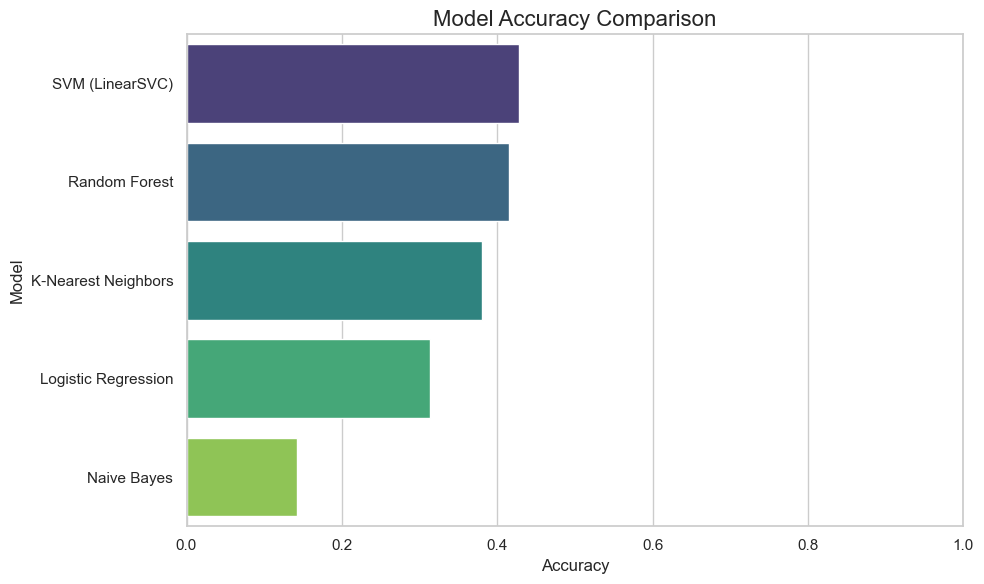

C:\Users\V2IN\AppData\Local\Temp\ipykernel_28116\124705022.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-score (macro avg)', y='Model', data=comparison_df_plot, palette='magma')


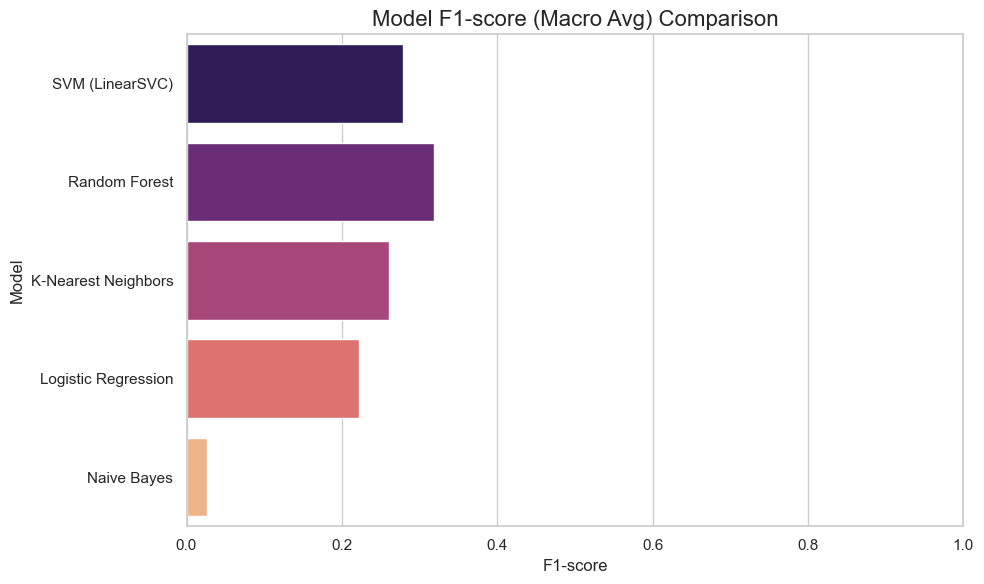

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Reset index for plotting
comparison_df_plot = comparison_df.reset_index().rename(columns={'index': 'Model'})

# Plot Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=comparison_df_plot, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Plot Macro F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(x='F1-score (macro avg)', y='Model', data=comparison_df_plot, palette='magma')
plt.title('Model F1-score (Macro Avg) Comparison', fontsize=16)
plt.xlabel('F1-score')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()